In [87]:
#coding:utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import NaN
%matplotlib inline

td = pd.read_csv('titanic-data.csv')
td.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 问题1：船上乘客的生还率和哪些因素密切相关？
## 数据清理：

下面探查一下需要用的列值的有效性，可以看出除了“Age”列有差不多20%的无效值外，其他跟问题密切相关的列都比较规整，没有非法值和空值。“Age”列的无效值全部都是空值，所以可以在使用前简单的通过dropna去除即可。

所以这里没有做单独的数据清洗操作，只是在针对各列做统计计算前，会使用dropna来去除空值，这个清洗操作会封装在统一调用的函数中。

In [88]:
def check_invalid(filter_series, col_name):
    df_invalid_sex = td[(td[col_name].isnull()) | filter_series]
    print "%s 字段的无效值的个数: %d(%0.2f)" % (col_name, df_invalid_sex.shape[0], df_invalid_sex.shape[0]*1.0/td.shape[0])

check_invalid((td['Survived'] != 0) & (td['Survived'] != 1), "Survived")
check_invalid((td['Sex'] != 'male') & (td['Sex'] != 'female'), "Sex")
check_invalid((td['Age']>110) | (td['Age']<0), "Age")
check_invalid(False, "Age")   #这里看一下Age列的空值有多少
check_invalid((td['Pclass']!=1) & (td['Pclass']!=2) & (td['Pclass']!=3) , "Pclass")
check_invalid((td['SibSp']<0) | (td['SibSp']>20) , "SibSp")
check_invalid((td['Parch']<0) | (td['Parch']>20) , "Parch")

Survived 字段的无效值的个数: 0(0.00)
Sex 字段的无效值的个数: 0(0.00)
Age 字段的无效值的个数: 177(0.20)
Age 字段的无效值的个数: 177(0.20)
Pclass 字段的无效值的个数: 0(0.00)
SibSp 字段的无效值的个数: 0(0.00)
Parch 字段的无效值的个数: 0(0.00)




## 公共计算逻辑抽象
下面构造了两个函数，这两个函数后续都有频繁的调用

* check_diff：在特定过滤条件下，计算指定列的各个值之间的占比
* check_hist：在特定过滤条件下，绘制指定列的的直方图

***

### *先看看生还率和性别之间的关系*

从下面的数据可以看出男性幸存者的比例明显偏小 男性人数占到了所有乘客的64.8%，但在幸存者中男性只占比31.9%

In [89]:
def check_diff(df, filter_series, col_name, kv):
    df2 = df
    if filter_series is not None:
        df2 = df[filter_series]
    one_col = df2[col_name]
    total_count = one_col.size
    msgs = []
    for key in kv:
        percent = 1.0*one_col[one_col==key].size / total_count
        msgs.append('%s: %f'%(kv[key], percent))
    print " ; ".join(msgs)

check_diff(td, None, 'Sex', {'male':'男性占比', 'female':'女性占比'})
check_diff(td, None, 'Survived', {0:'不在', 1:'幸存'})
check_diff(td, td.Survived==1, 'Sex', {'male':'幸存者中男性占比', 'female':'幸存者中女性占比'})

男性占比: 0.647587 ; 女性占比: 0.352413
不在: 0.616162 ; 幸存: 0.383838
幸存者中男性占比: 0.318713 ; 幸存者中女性占比: 0.681287


### *看一下生还率和年龄之间的关系*

从下面叠加的直方图中，可以看出只有0～8岁年龄段的乘客生还比例（高达66.7%）明显高于其他年龄段，除此之外的各年龄段生还比例没有显著差别。

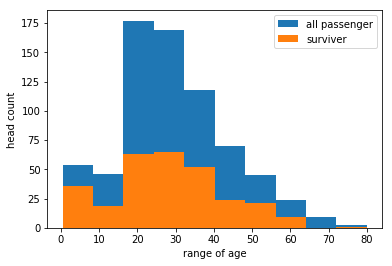

9岁以下儿童生还比例：66.7%


In [90]:
def check_hist(df, filter_series, col_name, bin_size=None):
    df2 = df
    if filter_series is not None:
        df2 = df[filter_series]
    plt.hist(df2[col_name].dropna(), bins=bin_size)

def check_hist2(df, filter_series, col_name):
    dfs = df[filter_series]
    plt.hist([df[col_name].dropna(), dfs[col_name].dropna()])

check_hist(td, None, "Age")
check_hist(td, td.Survived==1, "Age")
plt.ylabel("head count")
plt.xlabel("range of age")
plt.legend(["all passenger","surviver"])
plt.show()

survived_u9 = td[td.Survived==1].Age[td.Age<9].count()
all_u9 = td.Age[td.Age<9].count()
print "9岁以下儿童生还比例：%3.1f%%" % (survived_u9*100.0/all_u9)

### *看一下生还率和pclass（舱位等级）的关系*

从下面的图表和pie图，可以看出1等舱乘客的生还比例达到63%，其生还比例在所有舱位中占到了46.8%；2等舱，3等舱，生还比例逐渐在减小。

所以高等级舱位的乘客的生还概率明显比较大。

,各Pclass的乘客生还比例
Pclass,
1,0.629630
2,0.472826
3,0.242363


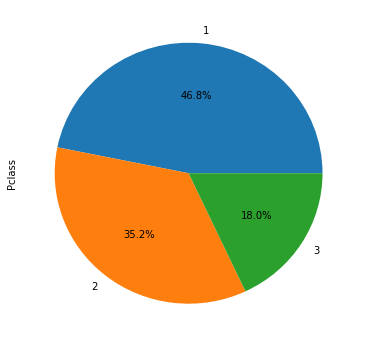

In [91]:
# check_hist(td, None, "Pclass")
# check_hist(td, td.Survived==1, "Pclass")
tds = td[td.Survived==1]
op = td.groupby("Pclass")['Pclass'].count()
osp = tds.groupby("Pclass")['Pclass'].count()
result_df = (osp*1.0/op)
result_df.plot.pie(figsize=(6, 6), autopct="%3.1f%%")
pd.DataFrame(data={"各Pclass的乘客生还比例":result_df})
# plt.ylabel("head count")
# plt.xlabel("Pclass")
# plt.legend(["all passenger","surviver"])
# plt.show()

### *看一下生还率和SibSp（同船兄弟姐妹或配偶个数）之间的关系*

（这里使用了上面的函数check_hist）

全体乘客和生还乘客的SibSp个数分布趋势相近，因此推测SibSp和是否生还关系不大

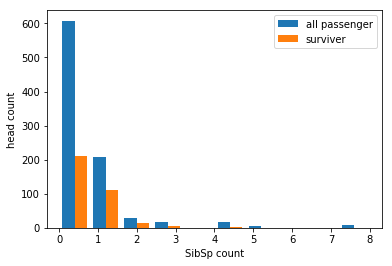

In [92]:
# check_hist(td, None, "SibSp",10)
# check_hist(td, td.Survived==1, "SibSp",10)

check_hist2(td, td.Survived==1, 'SibSp')
plt.ylabel("head count")
plt.xlabel("SibSp count")
plt.legend(["all passenger","surviver"])
plt.show()

### *看一下生还率和parch（同船父母或子女个数）之间的关系*

全体乘客和生还乘客的Parch个数分布趋势相近，因此推测Parch和是否生还关系不大

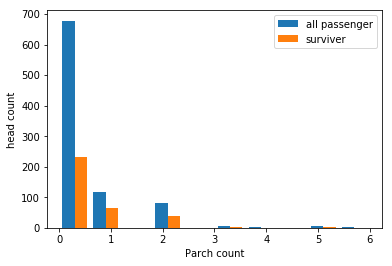

In [93]:
# check_hist(td, None, "Parch")
# check_hist(td, td.Survived==1, "Parch")

check_hist2(td, td.Survived==1, 'Parch')
plt.ylabel("head count")
plt.xlabel("Parch count")
plt.legend(["all passenger","surviver"])
plt.show()

### *看一下生还率和Parch与SibSp综合起来是否相关*

全体乘客和生还乘客的分布依然相近，所以Parch和SibSp综合起来看也和是否生还关系不大

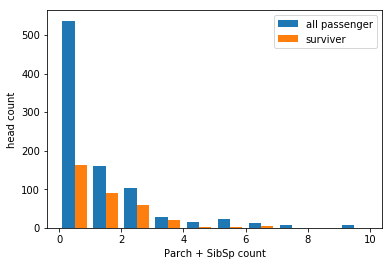

In [94]:
#增加一列'ParchPlusSibSp'，反映'Parch'和'SibSp'之和
td['ParchPlusSibSp'] = td['Parch']+td['SibSp']
# check_hist(td, None, "ParchPlusSibSp")
# check_hist(td, td.Survived==1, "ParchPlusSibSp")
check_hist2(td, td.Survived==1, 'ParchPlusSibSp')
plt.ylabel("head count")
plt.xlabel("Parch + SibSp count")
plt.legend(["all passenger","surviver"])
plt.show()


***

# 结论1
## 综上，可以得出结论，生还概率跟性别、舱位等级有着显著的相关性；另外，幼龄段（0～8岁）的乘客有着明显较高的生还概率

为了进一步验证结论，下面代码计算出了1，2，3等舱的男、女乘客总数和生还比例，这里把乘客总数列出来有助于观察会不会由于样本总数过少，造成比例计算失真。

从这组数字可以看出
>* 1，2等舱的女乘客的生还比例非常高（96.8%，92.1%），且1等舱高于2等舱
* 1，2等舱女乘客的生还比例显著高于3等舱女乘客（50%）
* 1，2，3等舱男乘客的生还比例同女乘客相比都比较低
* 只是1等舱男乘客的生还比例（36.9%）比较显著高于其他舱位的男乘客

In [95]:
for sex in ('female', 'male'):
    for pclass in range(1,4):
        filter = (td['Pclass']==pclass) & (td['Sex']==sex)
        print "%d等舱的%s乘客总数：%d" % (pclass, sex, td[filter].shape[0])
        check_diff(td, filter, 'Survived', {0:'不在', 1:'幸存'})
        print "*"*50
    print "\n"*2

1等舱的female乘客总数：94
不在: 0.031915 ; 幸存: 0.968085
**************************************************
2等舱的female乘客总数：76
不在: 0.078947 ; 幸存: 0.921053
**************************************************
3等舱的female乘客总数：144
不在: 0.500000 ; 幸存: 0.500000
**************************************************



1等舱的male乘客总数：122
不在: 0.631148 ; 幸存: 0.368852
**************************************************
2等舱的male乘客总数：108
不在: 0.842593 ; 幸存: 0.157407
**************************************************
3等舱的male乘客总数：347
不在: 0.864553 ; 幸存: 0.135447
**************************************************





# 问题2：泰坦尼克号船票的定价策略 （船票价格受哪些主要因素影响）

## 数据清理

Embarked列的无效值只有2个，基本可以忽略

船票价格（Fare）列的无效值和空值，因为占比（只有891-876=15条）不大，可以直接去除

In [96]:
print "Embarked列为无效值的纪录条数：", td[td['Embarked'].isnull()].shape[0]
print "*"*20
td2 = td[(td['Fare'] is not None) and (td['Fare']>0)]
print "原始记录数和去除Fare无效值之后的纪录数："
print td.shape, td2.shape

Embarked列为无效值的纪录条数： 2
********************
原始记录数和去除Fare无效值之后的纪录数：
(891, 13) (876, 13)


根据一般常识，船票价格收舱位等级和行程距离影响最大，这里假设目的地都一样，所以乘客的行程距离由登船地点（"Embarked"）。

下面看看"Fare"和"Pclass"、"Embarked"之间的关系，从打印的df数据表中可以看出：
* Pclass级别高的船票价格明显高于级别低的，但是同一Pclass内部价格差异很大，应该是跟别的变量相关
* Embarked为“C”和“Q”的纪录数据，在一个Pclass为2和为1时，数量较少，统计意义可能不大
* Embarked为“S”的纪录数量在所有Pclass中均有较大数量，所以下面主要考察Embarked为“S”的船票价格

In [97]:
grouped_fare = td2.groupby(['Pclass', 'Embarked'])['Fare']
df = pd.DataFrame()
df['mean'] = grouped_fare.mean()
df['max'] = grouped_fare.max()
df['min'] = grouped_fare.min()
df['count'] = grouped_fare.count()
df

mean       max      min  count
Pclass Embarked                                      
1      C         104.718529  512.3292  26.5500     85
       Q          90.000000   90.0000  90.0000      2
       S          73.248668  263.0000   5.0000    122
2      C          25.358335   41.5792  12.0000     17
       Q          12.350000   12.3500  12.3500      3
       S          21.099367   73.5000  10.5000    158
3      C          11.214083   22.3583   4.0125     66
       Q          11.183393   29.1250   6.7500     72
       S          14.811923   69.5500   6.2375    349

从下面的散点图可以看出，各Pclass级别的乘客中，年龄的差异分布为（15.5，14，12）；而其Fare的标准方差为（58.2, 13.3, 13.3）
* 各Pclass之间，乘客年龄的差异不大
* 票价跟年龄之间没有太大关系
* 船仓等级越高，票价波动幅度越大


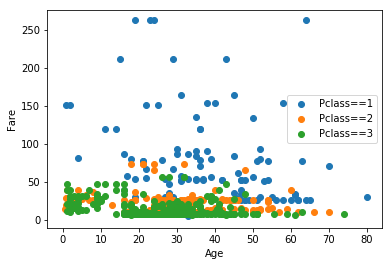

In [98]:
td2 = td2[td2['Embarked']=='S']

def draw_scatter(df, x_col, y_col):
    plt.scatter(df[x_col], df[y_col])
    
draw_scatter(td2[td2['Pclass']==1], 'Age', 'Fare')
draw_scatter(td2[td2['Pclass']==2], 'Age', 'Fare')
draw_scatter(td2[td2['Pclass']==3], 'Age', 'Fare')
plt.xlabel("Age")
plt.ylabel("Fare")
plt.legend(['Pclass==1','Pclass==2','Pclass==3'])

In [99]:
print "各Pclass舱位的乘客的年龄分布情况："
td2.groupby('Pclass')['Age'].describe()

各Pclass舱位的乘客的年龄分布情况：


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,105.0,38.127810,15.533605,0.92,28.0,36.0,48.00,80.0
2,156.0,30.386731,14.080001,0.67,23.0,30.0,38.25,70.0
3,286.0,25.604895,12.094925,1.00,19.0,25.0,32.00,74.0


In [100]:
print "各Pclass舱位的乘客的船票价格分布情况："
td2.groupby('Pclass')['Fare'].describe()

各Pclass舱位的乘客的船票价格分布情况：


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,122.0,73.248668,58.212627,5.0000,30.125,52.5542,85.74375,263.00
2,158.0,21.099367,13.285582,10.5000,13.000,14.5000,26.00000,73.50
3,349.0,14.811923,13.259006,6.2375,7.875,8.0500,16.10000,69.55






下面看看票价随同行乘客数量（SibSp＋Parch）之间的关系

从下面的散点图很惊讶的发现，在各个仓位级别船票价格和同行人员数量都没有太大关系！

/Users/puhui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


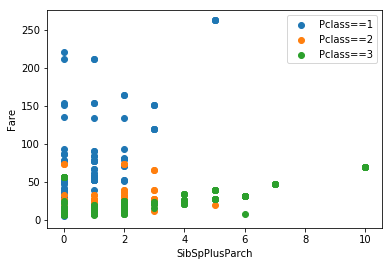

In [101]:
td2['SibSpPlusParch'] = td2['SibSp']+td2['Parch']
draw_scatter(td2[td2['Pclass']==1], 'SibSpPlusParch', 'Fare')
draw_scatter(td2[td2['Pclass']==2], 'SibSpPlusParch', 'Fare')
draw_scatter(td2[td2['Pclass']==3], 'SibSpPlusParch', 'Fare')
plt.xlabel('SibSpPlusParch')
plt.ylabel('Fare')
plt.legend(['Pclass==1','Pclass==2','Pclass==3'])

# 结论2

* 泰坦尼克船票价格随船仓等级的升高而显著提高
* 船票价格在高等级舱位上的波动明显大于低等级舱位
* 船票价格并没有随着同行人数的提高的有所降低，这可能跟泰坦尼克号的首次航行，船票供小于求有关系

***
## 以上两个结论只是根据项目提供的单一数据表计算观察得出，这个表中的数据只有较少的维度，很多其他可能会影响生还的因素和影响船票价格没有反映出来。因此，这只能作为一个暂时性的结论，更全面的结论需要基于更丰富的数据才能得出。